In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
# from stljax.expression import Expression
from stljax.formula import *
from stljax.viz import *


In [5]:
def dynamics_discrete_step(state, control):
    return state + control * 0.1

def simulate_dynamics(controls, state0):
    T = controls.shape[1]
    _states = [state0]
    for t in range(T):
        _states.append(dynamics_discrete_step(_states[-1], jnp.tanh(controls[:,t,:])))
    return jnp.concatenate(_states, 1)

### basic usage

In [3]:
# define expression (with None value)
distance_to_origin = Expression("magnitude", None, False)
formula = Eventually(distance_to_origin < 0.5)

In [4]:
# this will throw error since the expression value is None.
# formula(distance_to_origin)

AssertionError: Input Expression does not have numerical values

Array([[[-6.8423386],
        [-6.8423386],
        [-6.8423386],
        [-6.8423386],
        [-6.8423386],
        [-6.8423386],
        [-6.8423386],
        [-6.8423386],
        [-6.8423386],
        [-6.8423386],
        [-6.8346786],
        [-6.7764263],
        [-6.7680187],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037],
        [-6.6674037]]], dtype=float32)

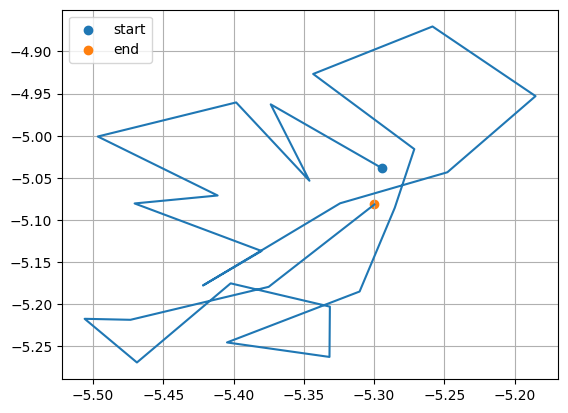

In [26]:
# populate expression with some values. In this example, using a control sequence to generate a state trajectory

T = 25
time_dim = 1
np.random.seed(123)
controls = jnp.array(np.random.randn(1,T,2))
state0 = jnp.array(np.random.randn(1,1,2)) - 4.0
states = simulate_dynamics(controls, state0)
states_norm = jnp.linalg.norm(states, axis=-1, keepdims=True)   # size [1, 26, 1]
distance_to_origin.set_value(states_norm)

distance_to_origin.flip(time_dim)


plt.plot(*states[0].T)
plt.scatter(states[0,0,:1], states[0,0,1:], label="start")
plt.scatter(states[0,-1,:1], states[0,-1,1:], label="end")
plt.legend()
plt.grid()
# will not throw an error now
formula(distance_to_origin)

In [56]:
# alternatively, we can just evaluate the robustness (trace) for any jnp.array, not necessarily an expression
key = jax.random.PRNGKey(123)  # Random seed is explicit in JAX
signal = jax.random.uniform(key, shape=(1, T, 1))  # assuming it's already reversed.
formula(signal)

# and we can take gradients with respect to the signal
def robustness_mean(signal, time_dim, **kwargs):
    return formula.robustness(signal, time_dim, **kwargs).mean()

jax.grad(robustness_mean)(signal, time_dim) # all zeros expect its -1 at the index where the point (0.5 - signal[index]) is the largest


# or you can use an approximation method (specify method and temperature), and the gradients should be "spread" to other indices as well
jax.grad(robustness_mean)(signal, time_dim, approx_method="logsumexp", temperature=10)

Array([[[-1.5154667e-04],
        [-2.2334205e-02],
        [-2.0218483e-04],
        [-1.8182890e-02],
        [-4.9155943e-02],
        [-3.6773860e-01],
        [-4.9805127e-02],
        [-1.2701885e-01],
        [-5.6684011e-04],
        [-1.2481150e-04],
        [-2.6030361e-03],
        [-2.5028756e-02],
        [-1.9274246e-02],
        [-2.1239769e-01],
        [-3.2680100e-03],
        [-1.0593031e-02],
        [-1.7588766e-03],
        [-1.0476990e-04],
        [-8.7516978e-03],
        [-9.4470056e-03],
        [-1.2794759e-02],
        [-2.3676397e-02],
        [-1.5461548e-03],
        [-3.2989861e-04],
        [-3.3144791e-02]]], dtype=float32)

### gradient descent on control inputs

In [73]:
np.random.seed(123)
controls = jnp.array(np.random.randn(1,T,2))
state0 = jnp.array(np.random.randn(1,1,2)) - 4.0

In [ ]:
distance_to_origin = Expression("magnitude", None, False)
formula = Eventually(distance_to_origin < 0.5)

In [74]:
u_max = 1.0
def loss(controls, state0, approx_method="true", temperature=None):
    # generate trajectory from control sequence and reverse
    traj_reversed = jnp.flip(simulate_dynamics(controls, state0), axis=1)
    # compute norm (reversed)
    distance_reversed = jnp.linalg.norm(traj_reversed, axis=-1, keepdims=True)
    return -formula.robustness(distance_reversed, time_dim=1, approx_method=approx_method, temperature=temperature).mean() + \
            0.1 * (jnp.diff(controls, axis=1)**2).sum(-1).mean() # can add other loss terms if desired. 

loss(controls, state0), loss(controls, state0, "logsumexp", 10)

(Array(7.197243, dtype=float32), Array(7.0332108, dtype=float32))

In [83]:
states_ = [simulate_dynamics(controls, state0)]
lr = 0.5 # learning rate
approx_method = "logsumexp"
temperature = 5

for i in range(100):
    g = jax.grad(loss, 0)(controls, state0, approx_method, temperature)
    controls -= g * jnp.ones_like(g) * lr
    states_.append(simulate_dynamics(controls, state0))
    if (i % 10) == 0:
        print(i, ": ", loss(controls, state0))

0 :  3.3327053
10 :  3.3314672
20 :  3.3302782
30 :  3.3291392
40 :  3.3280482
50 :  3.326999
60 :  3.3259902


KeyboardInterrupt: 

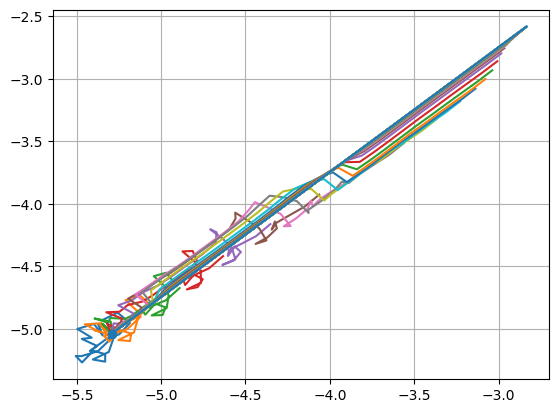

In [76]:
[plt.plot(*s[0].T) for s in states_[::10]]
plt.grid()
plt.scatter(states_[0][0,0,:1], states_[0][0,0,1:], zorder=10)

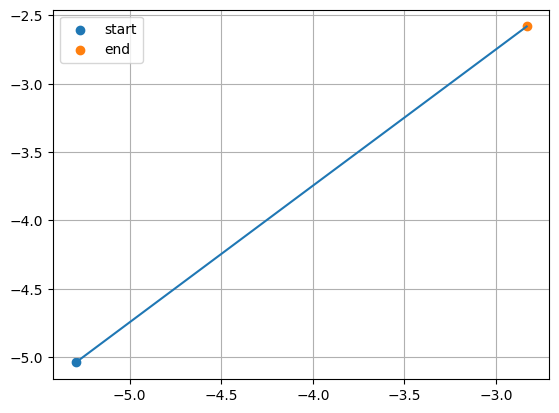

In [77]:

plt.plot(*states_[-1][0].T)
plt.scatter(states_[-1][0,0,:1], states_[-1][0,0,1:], label="start")
plt.scatter(states_[-1][0,-1,:1], states_[-1][0,-1,1:], label="end")
plt.legend()
plt.grid()

In [78]:
controls.shape

(1, 25, 2)

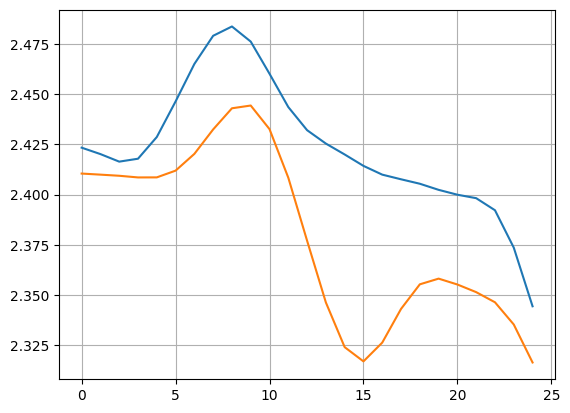

In [82]:
# plot control signal
plt.plot(controls[0,:,:1])
plt.plot(controls[0,:,1:])
plt.grid()

### some other stuff

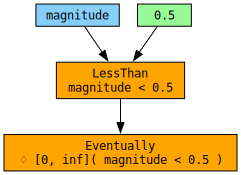

In [72]:
make_stl_graph(formula)